<a href="https://colab.research.google.com/github/Shadhujan/Baseline_FER/blob/main/Baseline_FER_Model_55perc_09_05_2025_123200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Environment Setup

In [ ]:
!pip install mtcnn tensorflow==2.12

import os
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks

2. Data Acquisition

2.1 FER2013 (48×48 greyscale, 7 emotions)
Where to download: Kaggle’s FER-2013 dataset → download the CSV or image files from Kaggle
Kaggle

Link: https://www.kaggle.com/datasets/msambare/fer2013

2.2 CAFE (Child Affective Facial Expression Set)
Where to download: Databrary (requires researcher registration)
childstudycenter

Link: https://databrary.org/volume/30

2.3 RaFD (Radboud Faces Database)**
Where to download: Official Radboud site (free for non-commercial academic use)
Radboud Faces Database

Link: http://www.socsci.ru.nl:8180/RaFD2/RaFD

3. Drive Mount & Storage
Mount Google Drive:

```
from google.colab import drive
drive.mount('/content/drive')
```

>This makes your Drive files available under /content/drive/MyDrive/


Folder Structure:
```
/content/drive/MyDrive/datasets/
    fer2013/
    cafe/
    rafd/
```


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from pathlib import Path

# 1. Paths to your zip files
zip_paths = [
    "/content/drive/MyDrive/datasets/FER-2013_v1.zip",
    "/content/drive/MyDrive/datasets/FER-2013_v2.zip",
    "/content/drive/MyDrive/datasets/archive.zip",
    "/content/drive/MyDrive/datasets/fer2013.csv.zip"
]

# 2. Create the dataset directory
dataset_dir = Path("/content/dataset")
dataset_dir.mkdir(parents=True, exist_ok=True)

# 3. Extract each zip
for zp in zip_paths:
    with zipfile.ZipFile(zp, 'r') as archive:
        archive.extractall(dataset_dir)
        print(f"Extracted {zp} ➔ {dataset_dir}")


Extracted /content/drive/MyDrive/datasets/FER-2013_v1.zip ➔ /content/dataset
Extracted /content/drive/MyDrive/datasets/FER-2013_v2.zip ➔ /content/dataset
Extracted /content/drive/MyDrive/datasets/archive.zip ➔ /content/dataset
Extracted /content/drive/MyDrive/datasets/fer2013.csv.zip ➔ /content/dataset


# **2. Data Generators**
>Use Keras’s flow_from_directory() to read labeled subfolders under your train/test paths.

In [ ]:
# 2.1 Augmentation & Rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen  = ImageDataGenerator(rescale=1./255)

# 2.2 Point to your directories
train_gen = train_datagen.flow_from_directory(
    '/content/dataset/train',        # train root folder
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical'         # one-hot labels for multiple emotions
)

test_gen = test_datagen.flow_from_directory(
    '/content/dataset/test',         # test root folder
    target_size=(48,48),
    batch_size=32,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


– flow_from_directory expects subfolders per class and yields batches at training time

4. Data Preparation
>4.1 Face Detection & Cropping

In [ ]:
detector = MTCNN()
def extract_face(img):
    res = detector.detect_faces(img)
    x,y,w,h = res[0]['box']
    return img[y:y+h, x:x+w]

>>4.2 Resize & Normalize

In [ ]:
import tensorflow as tf
def preprocess(img):
    face = extract_face(img)
    face = tf.image.resize(face, [48,48]) / 255.0
    return face


5. Model Definition & Training

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_gen.num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


3.2 Early Stopping & Fit


In [9]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=50,
    callbacks=[early_stop]
)


Epoch 1/50
898/898 [==============================] - 177s 196ms/step - loss: 1.7848 - accuracy: 0.2669 - val_loss: 1.6466 - val_accuracy: 0.3569
Epoch 2/50
898/898 [==============================] - 157s 175ms/step - loss: 1.6979 - accuracy: 0.3158 - val_loss: 1.5374 - val_accuracy: 0.3930
Epoch 3/50
898/898 [==============================] - 152s 169ms/step - loss: 1.6260 - accuracy: 0.3596 - val_loss: 1.4476 - val_accuracy: 0.4524
Epoch 4/50
898/898 [==============================] - 149s 166ms/step - loss: 1.5736 - accuracy: 0.3853 - val_loss: 1.4063 - val_accuracy: 0.4602
Epoch 5/50
898/898 [==============================] - 157s 174ms/step - loss: 1.5384 - accuracy: 0.4006 - val_loss: 1.3672 - val_accuracy: 0.4720
Epoch 6/50
898/898 [==============================] - 154s 171ms/step - loss: 1.5090 - accuracy: 0.4131 - val_loss: 1.3702 - val_accuracy: 0.4724
Epoch 7/50
898/898 [==============================] - 154s 172ms/step - loss: 1.4882 - accuracy: 0.4266 - val_loss: 1.3144 -

– Stops when validation loss stops improving to prevent overfitting

4. Evaluation & Inference
>4.1 Plot Metrics

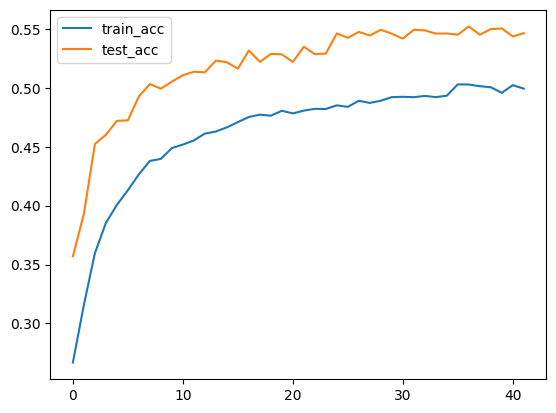

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.legend(); plt.show()


>>4.2 Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# Gather all test data and true labels
X_test, y_test = [], []
for X_batch, y_batch in test_gen:
    X_test.append(X_batch)
    y_test.append(y_batch)
    if len(X_test)*test_gen.batch_size >= test_gen.samples:
        break

X_test = np.vstack(X_test)
y_true = np.argmax(np.vstack(y_test), axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))


225/225 [==============================] - 6s 28ms/step
[[ 406    0   46  108  191  178   29]
 [  57    7    7    9   11   17    3]
 [ 157    0  162  104  212  247  142]
 [  48    0   24 1464  115   87   36]
 [  81    1   24  143  767  198   19]
 [ 114    0   48  143  339  583   20]
 [  40    0   46   66   82   23  574]]
              precision    recall  f1-score   support

       angry       0.45      0.42      0.44       958
     disgust       0.88      0.06      0.12       111
        fear       0.45      0.16      0.23      1024
       happy       0.72      0.83      0.77      1774
     neutral       0.45      0.62      0.52      1233
         sad       0.44      0.47      0.45      1247
    surprise       0.70      0.69      0.69       831

    accuracy                           0.55      7178
   macro avg       0.58      0.46      0.46      7178
weighted avg       0.55      0.55      0.53      7178



save

In [14]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [15]:
# 1. Save the entire model (architecture + weights + optimizer state) as a single file:
model.save('/content/drive/MyDrive/FER_model.h5')
# └─ you can also use .keras instead of .h5 in TF-Keras v3

# 2. (Optional) Or export in TensorFlow “SavedModel” format, which creates a folder:
model.save('/content/drive/MyDrive/FER_SavedModel', save_format='tf')

Quick sanity check

In [16]:
from tensorflow.keras.models import load_model
import numpy as np

# 1. Load
model = load_model('/content/drive/MyDrive/FER_model.h5')

# 2. Dummy input (batch of one 48×48 RGB face)
x = np.random.rand(1,48,48,3).astype('float32')
# 3. Run inference
print(model.predict(x))


1/1 [==============================] - 0s 154ms/step
[[0.14666557 0.02114715 0.1580859  0.11703003 0.20187008 0.28999558
  0.06520572]]


In [17]:
print(train_gen.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


test

In [20]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model

# Load model & detector once
model = load_model('/content/drive/MyDrive/FER_model.h5')
detector = MTCNN()
idx2label = {v:k for k,v in train_gen.class_indices.items()}

def predict_emotion(image_path):
    # 0) Check that it exists on disk
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    # 1) Read & convert to RGB
    img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError(f"cv2.imread failed for {image_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2) Detect face & crop
    faces = detector.detect_faces(img_rgb)
    if not faces:
        raise ValueError("No face detected in the image.")
    x,y,w,h = faces[0]['box']
    face = img_rgb[y:y+h, x:x+w]

    # 3) Resize & normalize
    face = cv2.resize(face, (48,48))
    face = face.astype('float32') / 255.0

    # 4) Predict
    probs = model.predict(np.expand_dims(face, 0))[0]
    best_idx = np.argmax(probs)
    return idx2label[best_idx], float(probs[best_idx])

# Example usage
img_path = '/content/drive/MyDrive/datasets/test/HappyKid.jpg'
label, confidence = predict_emotion(img_path)
print(f"Predicted emotion: {label} ({confidence*100:.1f}% confidence)")


1/1 [==============================] - 0s 150ms/step
Predicted emotion: happy (85.4% confidence)
